In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
import os

from deeplifting.models import DeepliftingSkipMLP
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import differential_evolution, dual_annealing
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import pygranso functions
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

In [ ]:
# from sklearn.manifold import TSNE
# import seaborn as sns
# import matplotlib.pyplot as plt

# target_names = ['setosa', 'other']
# # Apply t-SNE to the data
# tsne = TSNE(n_components=2, random_state=0)
# X_tsne = tsne.fit_transform(inputs_X.T[:, :-1])

# # Create a scatter plot
# # Create a scatter plot using matplotlib
# colors = ['red', 'blue', 'green']  # Define a color for each class
# for i in [-1, 1]:
#     plt.scatter(
#         X_tsne[predictions == i, 0],
#         X_tsne[predictions == i, 1],
#         c=colors[i],
#         label=target_names[i],
#         edgecolors='w',
#     )

# Let's clean up the SVM notebook

# Utilities

In [ ]:
# Build a utility for loading in the iris dataset with option for a test set
def build_iris_dataset(
    num_features=2, species_class=0, test_split=True, torch_version=False
):
    # Load the dataset
    iris = load_iris()

    # The data and target labels
    data = iris.data
    labels = iris.target

    # If you want the feature names and target names:
    feature_names = iris.feature_names
    target_names = iris.target_names

    df = pd.DataFrame(data=iris.data, columns=['f1', 'f2', 'f3', 'f4'])
    df['f5'] = 1.0
    df['labels'] = iris.target

    # Resample the data
    df = df.sample(frac=1.0).reset_index(drop=True)

    # Dimensions
    output_size = len(feature_names) + 1

    # Change features here
    if num_features == 2:
        columns = ['f1', 'f2', 'f5']
    elif num_features == 5:
        columns = ['f1', 'f2', 'f3', 'f4', 'f5']

    # Set up the variables
    y = df['labels'].values

    # Binarize the labels
    labels = np.zeros(len(y))
    labels[y != species_class] = -1
    labels[y == species_class] = 1
    y = labels.copy()

    X = df[columns].values

    # Sample the data into train and test
    if test_split:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        if torch_version:
            device = torch.device('cpu')
            # Torch X and y
            X_train = torch.from_numpy(X_train).to(device=device, dtype=torch.double)
            X_test = torch.from_numpy(X_test).to(device=device, dtype=torch.double)

            # y variables
            y_train = torch.from_numpy(y_train).to(device=device, dtype=torch.double)
            y_test = torch.from_numpy(y_test).to(device=device, dtype=torch.double)

        return {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
        }

    else:
        X = X.copy()
        y = y.copy()

        if torch_version:
            X = torch.from_numpy(X).to(device=device, dtype=torch.double)
            y = torch.from_numpy(y).to(device=device, dtype=torch.double)

        return {'X_train': X, 'y_train': y, 'X_test': None, 'y_test': None}


def build_mnist_dataset(number_class=0, test_split=True, torch_version=False):
    # Load the dataset
    # Load the MNIST dataset
    digits = load_digits()

    # Split the dataset into features and target variable
    X = digits.data / 255.0

    # If you want the feature names and target names:
    feature_names = digits.feature_names

    columns = [f'{i + 1}' for i in range(X.shape[1])]
    df = pd.DataFrame(data=X, columns=columns)
    df[f'f{X.shape[1] + 1}'] = 1.0

    # Dimensions
    output_size = len(feature_names) + 1

    # Set up the variables
    X = df.values
    y = digits.target

    # Binarize the labels
    labels = np.zeros(len(y))
    labels[y != number_class] = -1
    labels[y == number_class] = 1
    y = labels.copy()

    X = df[columns].values

    # Sample the data into train and test
    if test_split:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        if torch_version:
            device = torch.device('cpu')
            # Torch X and y
            X_train = torch.from_numpy(X_train).to(device=device, dtype=torch.double)
            X_test = torch.from_numpy(X_test).to(device=device, dtype=torch.double)

            # y variables
            y_train = torch.from_numpy(y_train).to(device=device, dtype=torch.double)
            y_test = torch.from_numpy(y_test).to(device=device, dtype=torch.double)

        return {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
        }

    else:
        X = X.copy()
        y = y.copy()

        if torch_version:
            X = torch.from_numpy(X).to(device=device, dtype=torch.double)
            y = torch.from_numpy(y).to(device=device, dtype=torch.double)

        return {'X_train': X, 'y_train': y, 'X_test': None, 'y_test': None}


def build_cifar100_dataset(image_class=46, test_split=True, torch_version=False):
    # Transformations applied to the dataset
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Load the CIFAR-100 dataset
    cifar100_dataset = datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform
    )

    # Split the dataset into features and target variable
    X = np.array([image.flatten().numpy() for image, label in cifar100_dataset])
    y = np.array([label for _, label in cifar100_dataset])

    columns = [f'{i + 1}' for i in range(X.shape[1])]
    df = pd.DataFrame(data=X, columns=columns)
    df[f'f{X.shape[1] + 1}'] = 1.0
    df['labels'] = y

    # Need a smaller sample
    df = df.sample(frac=0.30)

    X = df[columns + [f'f{X.shape[1] + 1}']].values
    y = df['labels'].values
    labels = np.zeros(len(y))
    labels[y == image_class] = 1
    labels[y != image_class] = -1
    y = labels.copy()

    # Sample the data into train and test
    if test_split:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        if torch_version:
            device = torch.device('cpu')
            # Convert X and y to Torch tensors
            X_train = torch.tensor(X_train).to(device=device, dtype=torch.double)
            X_test = torch.tensor(X_test).to(device=device, dtype=torch.double)
            y_train = torch.tensor(y_train).to(device=device, dtype=torch.double)
            y_test = torch.tensor(y_test).to(device=device, dtype=torch.double)

        return {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test,
        }

    else:
        X = X.copy()
        y = y.copy()

        if torch_version:
            device = torch.device('cpu')
            X = torch.tensor(X).to(device=device, dtype=torch.float32)
            y = torch.tensor(y).to(device=device, dtype=torch.long)

        return {'X_train': X, 'y_train': y, 'X_test': None, 'y_test': None}


# Set up the learning function this will be for algorithms such
# as dual annealing
def numpy_svm(weight_vec, inputs_X, labels):
    # Compute SVM objective
    denominator = np.linalg.norm(weight_vec, ord=2)
    prod = np.matmul(weight_vec.T, inputs_X)

    numerator = (labels * prod).flatten()
    obj = numerator / denominator

    # Orig obj
    f = np.amax(-1 * obj)
    return f


# Set up the learning function - this will be for PyGRANSO
def pygranso_svm(X_struct, inputs_X, labels):
    weight_vec = X_struct.w

    # Compute SVM objective
    denominator = torch.linalg.norm(weight_vec, ord=2)
    prod = torch.matmul(weight_vec.T, inputs_X)
    numerator = labels * prod
    obj = numerator / denominator

    # Orig obj
    f = torch.amax(-1 * obj)

    ce = None
    ci = None
    return f, ci, ce


# Set up the learning function
def deeplifting_svm(model, X, labels):
    outputs = model(None)
    weight_vec = outputs.mean(axis=0)

    # Compute SVM objective
    denominator = torch.linalg.norm(weight_vec, ord=2)
    prod = torch.matmul(weight_vec.T, X)
    numerator = labels * prod
    obj = numerator / denominator

    # Orig obj
    f = torch.amax(-1 * obj)

    ce = None
    ci = None
    return f, ci, ce


def run_dual_annealing_svm(X, labels):
    # Initialize a weight vector
    x0 = np.random.randn(X.shape[0])

    # Setup the objective function
    fn = lambda w: numpy_svm(w, X, labels)

    # For this problem we will set up arbitrary bounds
    bounds = [(-10, 10)] * X.shape[0]

    # Get the result
    result = dual_annealing(
        fn,
        bounds,
        x0=x0,
        maxiter=1000,
    )
    return result


def run_pygranso(X, labels):
    device = torch.device('cpu')
    w0 = torch.randn(
        (X.shape[0], 1),
    ).to(device, dtype=torch.double)
    var_in = {"w": list(w0.shape)}

    comb_fn = lambda X_struct: pygranso_svm(
        X_struct,
        X,
        labels,
    )

    opts = pygransoStruct()

    # PyGranso options
    # Increase max number of iterations and let convege to stationarity
    # Do we see local minima in the PyGranso version
    # Dual Annealing, SCIP and Deeplifting, PyGranso (showing there are local minima)
    opts.x0 = torch.reshape(w0, (-1, 1))
    opts.torch_device = device
    opts.print_frequency = 10
    opts.limited_mem_size = 5
    opts.stat_l2_model = False
    opts.double_precision = True
    opts.opt_tol = 1e-5
    opts.maxit = 10000

    # Run the main algorithm
    soln = pygranso(var_spec=var_in, combined_fn=comb_fn, user_opts=opts)
    return soln


def run_deeplifting(model, X, labels):
    # Deeplifting time!
    device = torch.device('cpu')
    model = model.to(device=device, dtype=torch.double)
    nvar = getNvarTorch(model.parameters())

    opts = pygransoStruct()

    # Inital x0
    x0 = (
        torch.nn.utils.parameters_to_vector(model.parameters())
        .detach()
        .reshape(nvar, 1)
        .to(device=device, dtype=torch.double)
    )

    # PyGranso options
    # Increase max number of iterations and let convege to stationarity
    # Do we see local minima in the PyGranso version
    # Dual Annealing, SCIP and Deeplifting, PyGranso (showing there are local minima)
    opts.x0 = x0
    opts.torch_device = device
    opts.print_frequency = 100
    opts.limited_mem_size = 100
    opts.stat_l2_model = False
    opts.double_precision = True
    opts.opt_tol = 1e-5
    opts.maxit = 6000

    # Combined function
    comb_fn = lambda model: deeplifting_svm(model, X, labels)  # noqa

    # Run the main algorithm
    soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)

    return soln


def build_predictions(w, X):
    predictions = np.sign(w @ X)
    return predictions

# Load in the Iris dataset (N Features = 2)

In [ ]:
# Data for the numpy version
data = build_iris_dataset(
    num_features=2, species_class=1, test_split=True, torch_version=False
)
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# Get data for the torch version
# Data for the numpy version
data = build_iris_dataset(
    num_features=2, species_class=1, test_split=True, torch_version=True
)
Xt_train = data['X_train']
yt_train = data['y_train']
Xt_test = data['X_test']
yt_test = data['y_test']

# Run Methods

# SCIPY Methods

In [ ]:
# Run the dual annealing version
dual_annealing_result = run_dual_annealing_svm(X_train.T, y_train)
print(dual_annealing_result.fun)
da_weights = dual_annealing_result.x

In [ ]:
# Train accuracy
preds_train = build_predictions(da_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(da_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train),
    accuracy_score(y_test, preds_test),
)

# PyGRANSO

In [ ]:
pygranso_result = run_pygranso(Xt_train.T, yt_train)
pg_weights = pygranso_result.best.x
pg_weights = pg_weights.detach().cpu().numpy().reshape(1, -1)

In [ ]:
# Train accuracy
preds_train = build_predictions(pg_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(pg_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# Deeplifting

In [ ]:
# Initialize the model outsize
model = DeepliftingSkipMLP(
    input_size=32,
    hidden_sizes=(128,) * 4,
    output_size=Xt_train.T.shape[0],
    bounds=None,
    skip_every_n=1,
    activation='sine',
    output_activation='sine',
    agg_function='identity',
    include_bn=True,
    seed=0,
)

dl_result = run_deeplifting(model, Xt_train.T, yt_train)
dl_weights = model(inputs=None)
dl_weights = dl_weights.mean(axis=0)
dl_weights = dl_weights.detach().cpu().numpy().flatten().reshape(1, -1)

In [ ]:
# Train accuracy
preds_train = build_predictions(dl_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(dl_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# Landscape of the function

In [ ]:
# Fix the last weight and let's look at the landscape!
W2 = dl_weights.flatten()[-1]

resolution = 500
W0_range = np.linspace(-2, 2, resolution)
W1_range = np.linspace(-2, 2, resolution)
objective_value = np.zeros((resolution, resolution))

for i, W0 in enumerate(W0_range):
    for j, W1 in enumerate(W1_range):
        W = np.array([W0, W1, W2]).reshape(-1, 1)
        objective_value[i, j] = numpy_svm(W, X_train.T, y_train)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)

# Plot the weights vs. the loss landscale
c1 = ax.contourf(
    W0_range, W1_range, objective_value, levels=100, cmap='jet', extend='both'
)
fig.colorbar(c1, orientation='vertical')

In [ ]:
# Create a new figure
fig = plt.figure()

# Create 3D axis
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(W0_range, W1_range, objective_value, cmap='jet')

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot')

# Show the plot
plt.show()

# Load in Iris (N Features = 5 & Label = 1)

In [ ]:
# Data for the numpy version
data = build_iris_dataset(
    num_features=5, species_class=1, test_split=True, torch_version=False
)
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# Get data for the torch version
# Data for the numpy version
data = build_iris_dataset(num_features=5, test_split=True, torch_version=True)
Xt_train = data['X_train']
yt_train = data['y_train']
Xt_test = data['X_test']
yt_test = data['y_test']

# SCIPY Methods

In [ ]:
# Run the dual annealing version
dual_annealing_result = run_dual_annealing_svm(X_train.T, y_train)
da_weights = dual_annealing_result.x

# Train accuracy
preds_train = build_predictions(da_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(da_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train),
    accuracy_score(y_test, preds_test),
)

# PyGRANSO

In [ ]:
pygranso_result = run_pygranso(Xt_train.T, yt_train)
pg_weights = pygranso_result.best.x
pg_weights = pg_weights.detach().cpu().numpy().reshape(1, -1)

# Train accuracy
preds_train = build_predictions(pg_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(pg_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# Deeplifting

In [ ]:
# Initialize the model outsize
model = DeepliftingSkipMLP(
    input_size=32,
    hidden_sizes=(128,) * 3,
    output_size=Xt_train.T.shape[0],
    bounds=None,
    skip_every_n=1,
    activation='leaky_relu',
    output_activation='sine',
    agg_function='identity',
    include_bn=True,
    seed=0,
)

dl_result = run_deeplifting(model, Xt_train.T, yt_train)
dl_weights = model(inputs=None)
dl_weights = dl_weights.mean(axis=0)
dl_weights = dl_weights.detach().cpu().numpy().flatten().reshape(1, -1)

In [ ]:
# Train accuracy
preds_train = build_predictions(dl_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(dl_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# Let's work on the MNIST dataset

In [ ]:
data = build_mnist_dataset(number_class=0, test_split=True, torch_version=False)
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# Torch data
data = build_mnist_dataset(number_class=0, test_split=True, torch_version=True)
Xt_train = data['X_train']
yt_train = data['y_train']
Xt_test = data['X_test']
yt_test = data['y_test']

# SCIPY Methods!

In [ ]:
# Run the dual annealing version
dual_annealing_result = run_dual_annealing_svm(X_train.T, y_train)
da_weights = dual_annealing_result.x

# Train accuracy
preds_train = build_predictions(da_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(da_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train),
    accuracy_score(y_test, preds_test),
)

# PyGRANSO Methods

In [ ]:
pygranso_result = run_pygranso(Xt_train.T, yt_train)
pg_weights = pygranso_result.best.x
pg_weights = pg_weights.detach().cpu().numpy().reshape(1, -1)

# Train accuracy
preds_train = build_predictions(pg_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(pg_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# Deeplifting!

In [ ]:
# Initialize the model outsize
model = DeepliftingSkipMLP(
    input_size=32,
    hidden_sizes=(128,) * 3,
    output_size=Xt_train.T.shape[0],
    bounds=None,
    skip_every_n=1,
    activation='leaky_relu',
    output_activation='sine',
    agg_function='identity',
    include_bn=True,
    seed=0,
)

dl_result = run_deeplifting(model, Xt_train.T, yt_train)
dl_weights = model(inputs=None)
dl_weights = dl_weights.mean(axis=0)
dl_weights = dl_weights.detach().cpu().numpy().flatten().reshape(1, -1)

In [ ]:
# Train accuracy
preds_train = build_predictions(dl_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(dl_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# CIFAR 100

In [ ]:
# Numpy data
data = build_cifar100_dataset(image_class=46, test_split=True, torch_version=False)
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

# Torch data
data = build_cifar100_dataset(image_class=46, test_split=True, torch_version=True)
Xt_train = data['X_train']
yt_train = data['y_train']
Xt_test = data['X_test']
yt_test = data['y_test']

In [ ]:
# Verifty the shapes of the data
X_train.shape, y_train.shape

# SCIPY Methods!

In [ ]:
# Run the dual annealing version
dual_annealing_result = run_dual_annealing_svm(X_train.T, y_train)
da_weights = dual_annealing_result.x

# Train accuracy
preds_train = build_predictions(da_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(da_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train),
    accuracy_score(y_test, preds_test),
)

# PyGRANSO

In [ ]:
pygranso_result = run_pygranso(Xt_train.T, yt_train)
pg_weights = pygranso_result.best.x
pg_weights = pg_weights.detach().cpu().numpy().reshape(1, -1)

# Train accuracy
preds_train = build_predictions(pg_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(pg_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# Deeplifting!

In [ ]:
# Initialize the model outsize
model = DeepliftingSkipMLP(
    input_size=64,
    hidden_sizes=(128,) * 3,
    output_size=Xt_train.T.shape[0],
    bounds=None,
    skip_every_n=1,
    activation='leaky_relu',
    output_activation='sine',
    agg_function='identity',
    include_bn=True,
    seed=0,
)

dl_result = run_deeplifting(model, Xt_train.T, yt_train)
dl_weights = model(inputs=None)
dl_weights = dl_weights.mean(axis=0)
dl_weights = dl_weights.detach().cpu().numpy().flatten().reshape(1, -1)

In [ ]:
# Train accuracy
preds_train = build_predictions(dl_weights, X_train.T)

# Test accuracy
preds_test = build_predictions(dl_weights, X_test.T)

print(
    accuracy_score(y_train, preds_train.flatten()),
    accuracy_score(y_test, preds_test.flatten()),
)

# Diagnostics for SVM

In [11]:
save_path = os.path.join(
    os.getcwd(), 'data-queue-2023-09-24', 'svm', 'svm-deeplifting-results.parquet'
)
svm_deeplifting_df = pd.read_parquet(save_path)
svm_deeplifting_df.head()

,values,metric,trial,iteration,problem_name,total_time
0,1.793904,Objective,0,0,CIFAR-100,38402.284719
1,1.454346,Objective,0,1,CIFAR-100,38402.284719
2,1.191287,Objective,0,2,CIFAR-100,38402.284719
3,0.981433,Objective,0,3,CIFAR-100,38402.284719
4,0.975419,Objective,0,4,CIFAR-100,38402.284719


In [12]:
svm_deeplifting_df.groupby('trial').size()

trial
0    30003
1      240
2        9
3       21
4       36
5       21
6       30
7      144
8       78
9      237
dtype: int64

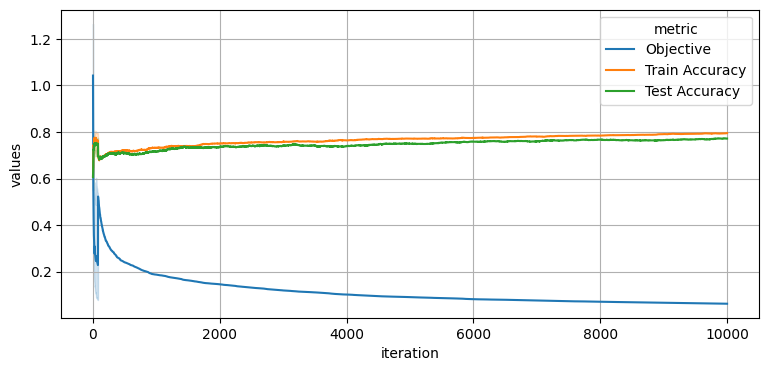

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
sns.lineplot(
    data=svm_deeplifting_df,
    x='iteration',
    y='values',
    hue='metric',
    ax=ax,
)
ax.grid()

In [22]:
svm_final_df = svm_deeplifting_df.groupby(['trial', 'metric']).last().reset_index()
svm_final_df

,trial,metric,values,iteration,problem_name,total_time
0,0,Objective,0.061813,10000,CIFAR-100,38402.284719
1,0,Test Accuracy,0.772000,10000,CIFAR-100,38402.284719
2,0,Train Accuracy,0.795125,10000,CIFAR-100,38402.284719
3,1,Objective,0.081571,79,CIFAR-100,105.320961
4,1,Test Accuracy,0.772500,79,CIFAR-100,105.320961
5,1,Train Accuracy,0.792125,79,CIFAR-100,105.320961
6,2,Objective,0.708929,2,CIFAR-100,9.832695
7,2,Test Accuracy,0.684000,2,CIFAR-100,9.832695
8,2,Train Accuracy,0.700250,2,CIFAR-100,9.832695
9,3,Objective,0.622674,6,CIFAR-100,12.376424


<Axes: xlabel='trial', ylabel='values'>

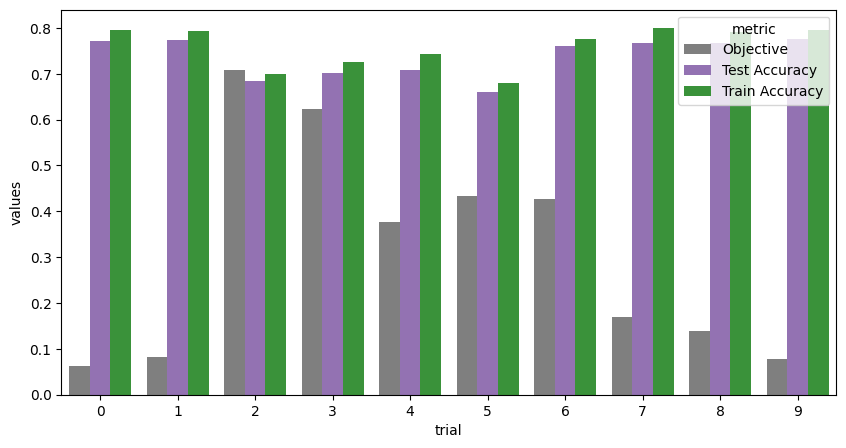

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.barplot(
    data=svm_final_df, x='trial', y='values', hue='metric', palette='tab10_r', ax=ax
)